# 取引所の価格差
## 環境設定

In [5]:
# django
MYPROJECT = '/home/notebooks'
import os, sys
sys.path.insert(0, MYPROJECT)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")
import django
django.setup()
from bot.models import Exchange

# matplotlib
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib.ticker as ticker
import sqlite3
from django_pandas.io import read_frame
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 12
import numpy as np

# timezone
from datetime import datetime, timedelta
from django.utils import timezone
import pytz
timezone.now()
first_date = datetime(2018, 6, 20, tzinfo=pytz.UTC)
last_date = datetime(2018, 6, 21, tzinfo=pytz.UTC)

def make_subset(exchange: Exchange, first_date: datetime, last_date: datetime) -> pd.DataFrame:
    ex = Exchange.objects \
        .filter(name=exchange, created_at__range=(first_date, last_date)) \
        .extra(select={'time': "strftime('%%Y-%%m-%%d %%H:%%M', created_at)"}) \
        .values('time', 'btc_jpy_bid', 'btc_jpy_ask', 'created_at') \
        .order_by('time')
    rf = read_frame(ex, index_col='time')
    rf = rf[~rf.index.duplicated(keep='first')]
    rf.index = pd.to_datetime(rf.index)
    return rf.resample('T').fillna(method='ffill')

## CoincheckとBitflyerの価格差

In [6]:
cc = make_subset(Exchange.CC, first_date, last_date)
bf = make_subset(Exchange.BF, first_date, last_date)

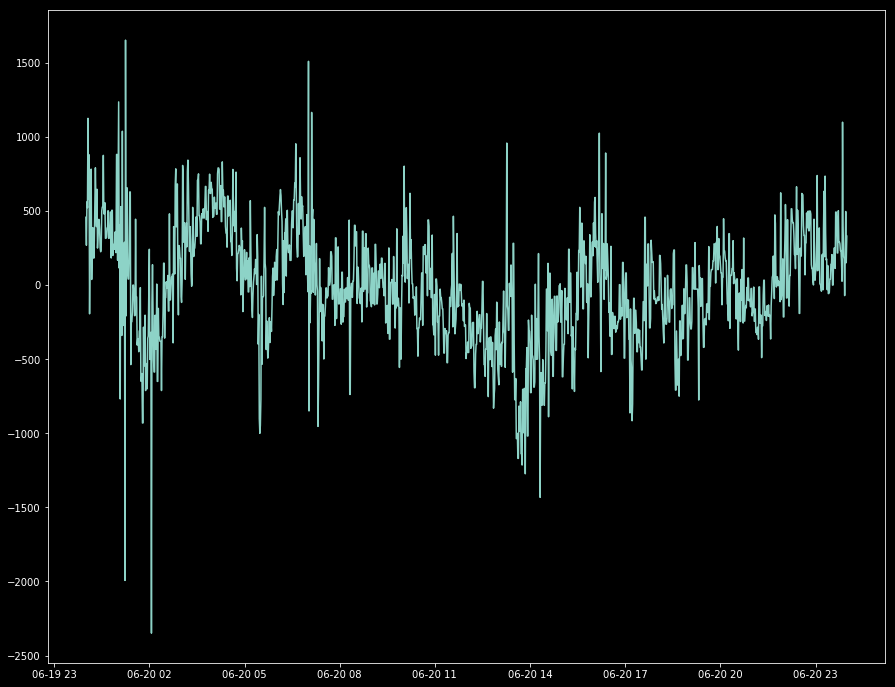

In [7]:
diff = np.array(bf['btc_jpy_ask'].astype(float)) - np.array(cc['btc_jpy_ask'].astype(float))
plt.plot(bf.index, pd.Series(diff), color='C0', label="bf")